# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# base
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV,
)

# preprocessing and pipeline (workflow)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_squared_error,
    precision_score, 
    recall_score,
    f1_score,
    make_scorer, 
    accuracy_score
)

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


# Import cleaned data

In [2]:
df = pd.read_csv("../data/summer_men_swimming.csv")

In [3]:
df.head()

,Unnamed: 0,Name,Age,Height,Weight,NOC,Year,City,Sport,Event,Medal,Times_Participated,Participation_Number
0,29,"Einar Ferdinand ""Einari"" Aalto",26.0,182.850556,76.743311,FIN,1952,Helsinki,Swimming,Swimming Men's 400 metres Freestyle,no medal,1,1
1,35,Arvo Ossian Aaltonen,22.0,182.008432,76.694056,FIN,1912,Stockholm,Swimming,Swimming Men's 200 metres Breaststroke,no medal,3,1
2,36,Arvo Ossian Aaltonen,22.0,177.000000,75.000000,FIN,1912,Stockholm,Swimming,Swimming Men's 400 metres Breaststroke,no medal,3,1
3,37,Arvo Ossian Aaltonen,30.0,182.008432,76.694056,FIN,1920,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze,3,2
4,38,Arvo Ossian Aaltonen,30.0,177.000000,75.000000,FIN,1920,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze,3,2


In [4]:
df = df.drop(columns=["Unnamed: 0"])

In [5]:
print(df.shape)
df.head()

(12506, 12)


,Name,Age,Height,Weight,NOC,Year,City,Sport,Event,Medal,Times_Participated,Participation_Number
0,"Einar Ferdinand ""Einari"" Aalto",26.0,182.850556,76.743311,FIN,1952,Helsinki,Swimming,Swimming Men's 400 metres Freestyle,no medal,1,1
1,Arvo Ossian Aaltonen,22.0,182.008432,76.694056,FIN,1912,Stockholm,Swimming,Swimming Men's 200 metres Breaststroke,no medal,3,1
2,Arvo Ossian Aaltonen,22.0,177.000000,75.000000,FIN,1912,Stockholm,Swimming,Swimming Men's 400 metres Breaststroke,no medal,3,1
3,Arvo Ossian Aaltonen,30.0,182.008432,76.694056,FIN,1920,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze,3,2
4,Arvo Ossian Aaltonen,30.0,177.000000,75.000000,FIN,1920,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze,3,2


In [6]:
df.isna().sum()

Name                    0
Age                     0
Height                  0
Weight                  0
NOC                     0
Year                    0
City                    0
Sport                   0
Event                   0
Medal                   0
Times_Participated      0
Participation_Number    0
dtype: int64

## Preprocessing

### Split data into train and test

In [7]:
X = df.drop(columns=["Medal"])      # 
y = df["Medal"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55, stratify=y)      
X_train.shape, X_test.shape

((10004, 11), (2502, 11))

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10004 entries, 6535 to 947
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  10004 non-null  object 
 1   Age                   10004 non-null  float64
 2   Height                10004 non-null  float64
 3   Weight                10004 non-null  float64
 4   NOC                   10004 non-null  object 
 5   Year                  10004 non-null  int64  
 6   City                  10004 non-null  object 
 7   Sport                 10004 non-null  object 
 8   Event                 10004 non-null  object 
 9   Times_Participated    10004 non-null  int64  
 10  Participation_Number  10004 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 937.9+ KB


### Separate categorical and numerical features

In [10]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

categorical_features, numeric_features

(['Name', 'NOC', 'City', 'Sport', 'Event'],
 ['Age',
  'Height',
  'Weight',
  'Year',
  'Times_Participated',
  'Participation_Number'])

### Define transformers pipelines

#### Standard transformer

In [11]:
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
categorical_transformer

,steps,"[('onehot', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [12]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler().set_output(transform="pandas"))])
numeric_transformer

,steps,"[('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True


In [13]:
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer, categorical_features)
                                               ]).set_output(transform="pandas")
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


#### Transformer for decision trees 
(since they don't require scaling)

In [14]:
categorical_transformer_tree = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])

preprocessor_tree = ColumnTransformer(transformers=[("num", "passthrough", numeric_features),       # passthrough -> does nothing, no scaling
                                                    ("cat", categorical_transformer_tree, categorical_features)
                                                    ]).set_output(transform="pandas")
preprocessor_tree

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,False


# Models

### Create a dataframe to keep scores

In [15]:
scores_df = pd.DataFrame(columns=[
    "model_name",
    "F1",
    "Precision",
    "Recall",
])

scores_df

,model_name,F1,Precision,Recall


In [16]:
def add_row(df, y_test=None, y_pred=None, model_name=None):
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    new_row = {
        "model_name": model_name,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
    }

    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df

### Train and evaluate different models

#### Logistic regression

##### Initialize model and build pipeline

In [17]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [18]:
pipeline_lr = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("model", lr_model)
                              ])
pipeline_lr

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [19]:
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

class_labels = pipeline_lr.named_steps['model'].classes_

print(classification_report(y_test, y_pred_lr))

pd.DataFrame(confusion_matrix(y_test, y_pred_lr),
             columns=class_labels, index=class_labels)

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00        91
        Gold       0.60      0.51      0.55       114
      Silver       0.29      0.02      0.04        91
    no medal       0.92      1.00      0.96      2206

    accuracy                           0.90      2502
   macro avg       0.45      0.38      0.39      2502
weighted avg       0.85      0.90      0.87      2502



,Bronze,Gold,Silver,no medal
Bronze,0,11,0,80
Gold,3,58,3,50
Silver,2,22,2,65
no medal,1,6,2,2197


##### Save scores

 Note &rarr; average= 
- 'macro' for equal weight for each medal type
- 'weighted' if some medal types are much more common than others to account for class imbalance

In [20]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_lr, model_name="Logistic Regression")
scores_df

C:\Users\Catalina\AppData\Local\Temp\ipykernel_87896\3027274401.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


,model_name,F1,Precision,Recall
0,Logistic Regression,0.86911,0.847453,0.902078


#### KNN classifier

##### Initialize model and build pipeline

In [21]:
knn = KNeighborsClassifier()
knn

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [22]:
pipeline_knn = Pipeline([("pre_process", preprocessor),
                         ("model", knn)])
pipeline_knn

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [23]:
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)

class_labels = pipeline_knn.named_steps['model'].classes_

print(classification_report(y_test, y_pred_knn))

pd.DataFrame(confusion_matrix(y_test, y_pred_knn),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.35      0.10      0.15        91
        Gold       0.60      0.47      0.53       114
      Silver       0.38      0.15      0.22        91
    no medal       0.92      0.98      0.95      2206

    accuracy                           0.90      2502
   macro avg       0.56      0.43      0.46      2502
weighted avg       0.87      0.90      0.88      2502



,Bronze,Gold,Silver,no medal
Bronze,9,13,2,67
Gold,2,54,8,50
Silver,2,10,14,65
no medal,13,13,13,2167


##### Save scores

In [24]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_knn, model_name="KNN Regression")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.86911,0.847453,0.902078
1,KNN Regression,0.87659,0.867071,0.896882


#### Naive Bayes

##### Initialize model and build pipeline

In [25]:
nb = BernoulliNB()
nb

,alpha,1.0
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


In [26]:
pipeline_nb = Pipeline([("pre_process", preprocessor),
                        ("model", nb)])
pipeline_nb

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [27]:
pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)

class_labels = pipeline_nb.named_steps['model'].classes_

print(classification_report(y_test, y_pred_nb))

pd.DataFrame(confusion_matrix(y_test, y_pred_nb),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00        91
        Gold       0.00      0.00      0.00       114
      Silver       0.00      0.00      0.00        91
    no medal       0.88      1.00      0.94      2206

    accuracy                           0.88      2502
   macro avg       0.22      0.25      0.23      2502
weighted avg       0.78      0.88      0.83      2502



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,0,91
Gold,0,0,0,114
Silver,0,0,0,91
no medal,0,0,0,2206


##### Save scores

In [28]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_nb, model_name="Naive Bayes")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.869110,0.847453,0.902078
1,KNN Regression,0.876590,0.867071,0.896882
2,Naive Bayes,0.826261,0.777385,0.881695


#### SVM classifier

##### Linear Support vector classification

###### Initialize model and build pipeline

In [29]:
svm = LinearSVC()
svm

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [30]:
pipeline_svm = Pipeline([("pre_process", preprocessor),
                         ("model", svm)])
pipeline_svm

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


###### Train and evaluate model

In [31]:
pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)

class_labels = pipeline_svm.named_steps['model'].classes_

print(classification_report(y_test, y_pred_svm))

pd.DataFrame(confusion_matrix(y_test, y_pred_svm),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.15      0.08      0.10        91
        Gold       0.48      0.47      0.48       114
      Silver       0.22      0.09      0.13        91
    no medal       0.93      0.97      0.95      2206

    accuracy                           0.89      2502
   macro avg       0.45      0.40      0.41      2502
weighted avg       0.86      0.89      0.87      2502



,Bronze,Gold,Silver,no medal
Bronze,7,14,5,65
Gold,12,54,7,41
Silver,7,23,8,53
no medal,21,22,16,2147


###### Save scores

In [32]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_svm, model_name="Linear SVC")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.869110,0.847453,0.902078
1,KNN Regression,0.876590,0.867071,0.896882
2,Naive Bayes,0.826261,0.777385,0.881695
3,Linear SVC,0.869045,0.856174,0.885691


##### Support vector classification with Radial basis function

###### Initialize model and build pipeline

In [33]:
svm_rbf = SVC(kernel="rbf", gamma="scale")
svm_rbf

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [34]:
pipeline_svm_rbf = Pipeline([("pre_process", preprocessor),
                             ("model", svm_rbf)])
pipeline_svm_rbf

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


###### Train and evaluate model

In [35]:
pipeline_svm_rbf.fit(X_train, y_train)
y_pred_svm_rbf = pipeline_svm_rbf.predict(X_test)

class_labels = pipeline_svm_rbf.named_steps['model'].classes_

print(classification_report(y_test, y_pred_svm_rbf))

pd.DataFrame(confusion_matrix(y_test, y_pred_svm_rbf),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00        91
        Gold       0.73      0.54      0.62       114
      Silver       0.00      0.00      0.00        91
    no medal       0.91      1.00      0.95      2206

    accuracy                           0.90      2502
   macro avg       0.41      0.38      0.39      2502
weighted avg       0.84      0.90      0.87      2502



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,7,0,84
Gold,0,61,0,53
Silver,0,13,0,78
no medal,0,3,0,2203


###### Save scores

In [36]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_svm_rbf, model_name="SVC with radial basis")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.869110,0.847453,0.902078
1,KNN Regression,0.876590,0.867071,0.896882
2,Naive Bayes,0.826261,0.777385,0.881695
3,Linear SVC,0.869045,0.856174,0.885691
4,SVC with radial basis,0.868201,0.836385,0.904876


#### Decision tree

##### Initialize model and build pipeline

In [37]:
dtree = DecisionTreeClassifier(random_state=42)
dtree

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [38]:
pipeline_dtree = Pipeline([("pre_process", preprocessor_tree),
                           ("model", dtree)])
pipeline_dtree

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [39]:
pipeline_dtree.fit(X_train, y_train)
y_pred_dt = pipeline_dtree.predict(X_test)

class_labels = pipeline_dtree.named_steps['model'].classes_

print(classification_report(y_test, y_pred_dt))

pd.DataFrame(confusion_matrix(y_test, y_pred_dt),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.32      0.27      0.29        91
        Gold       0.66      0.62      0.64       114
      Silver       0.38      0.37      0.38        91
    no medal       0.95      0.96      0.95      2206

    accuracy                           0.89      2502
   macro avg       0.57      0.56      0.57      2502
weighted avg       0.89      0.89      0.89      2502



,Bronze,Gold,Silver,no medal
Bronze,25,10,7,49
Gold,4,71,11,28
Silver,6,10,34,41
no medal,44,17,38,2107


##### Save scores

In [40]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_dt, model_name="Decision Tree")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.869110,0.847453,0.902078
1,KNN Regression,0.876590,0.867071,0.896882
2,Naive Bayes,0.826261,0.777385,0.881695
3,Linear SVC,0.869045,0.856174,0.885691
4,SVC with radial basis,0.868201,0.836385,0.904876
5,Decision Tree,0.892021,0.890139,0.894085


#### Random forest

##### Initialize model and build pipeline

In [41]:
rf = RandomForestClassifier(random_state=42)
rf

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [42]:
pipeline_rf = Pipeline([("pre_process", preprocessor_tree),
                         ("model", rf)])
pipeline_rf

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [43]:
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

class_labels = pipeline_rf.named_steps['model'].classes_

print(classification_report(y_test, y_pred_rf))

pd.DataFrame(confusion_matrix(y_test, y_pred_rf),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.22      0.02      0.04        91
        Gold       0.67      0.57      0.62       114
      Silver       0.50      0.05      0.10        91
    no medal       0.92      0.99      0.96      2206

    accuracy                           0.91      2502
   macro avg       0.58      0.41      0.43      2502
weighted avg       0.87      0.91      0.88      2502



,Bronze,Gold,Silver,no medal
Bronze,2,9,0,80
Gold,0,65,3,46
Silver,4,16,5,66
no medal,3,7,2,2194


##### Save scores

In [44]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_rf, model_name="Random Forest")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.869110,0.847453,0.902078
1,KNN Regression,0.876590,0.867071,0.896882
2,Naive Bayes,0.826261,0.777385,0.881695
3,Linear SVC,0.869045,0.856174,0.885691
4,SVC with radial basis,0.868201,0.836385,0.904876
5,Decision Tree,0.892021,0.890139,0.894085
6,Random Forest,0.875654,0.867545,0.905675


#### AdaBoost

You do not need to scale numerical data for AdaBoostClassifier, especially when using DecisionTreeClassifier as the base estimator (which is the default)

##### Initialize model and build pipeline

In [45]:
ada_boost = AdaBoostClassifier(random_state=42)
ada_boost

,estimator,None
,n_estimators,50
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42


In [46]:
pipeline_ada_boost = Pipeline([("pre_process", preprocessor_tree),
                               ("model", ada_boost)])
pipeline_ada_boost

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [47]:
pipeline_ada_boost.fit(X_train, y_train)
y_pred_ada = pipeline_ada_boost.predict(X_test)

class_labels = pipeline_ada_boost.named_steps['model'].classes_

print(classification_report(y_test, y_pred_ada))

pd.DataFrame(confusion_matrix(y_test, y_pred_ada),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00        91
        Gold       0.49      0.61      0.54       114
      Silver       0.00      0.00      0.00        91
    no medal       0.92      0.99      0.95      2206

    accuracy                           0.90      2502
   macro avg       0.35      0.40      0.37      2502
weighted avg       0.83      0.90      0.86      2502



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,17,0,74
Gold,0,69,0,45
Silver,0,23,0,68
no medal,0,32,0,2174


##### Save scores

In [48]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_ada, model_name="AdaBoost")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.869110,0.847453,0.902078
1,KNN Regression,0.876590,0.867071,0.896882
2,Naive Bayes,0.826261,0.777385,0.881695
3,Linear SVC,0.869045,0.856174,0.885691
4,SVC with radial basis,0.868201,0.836385,0.904876
5,Decision Tree,0.892021,0.890139,0.894085
6,Random Forest,0.875654,0.867545,0.905675
7,AdaBoost,0.864073,0.834158,0.896483


#### Gradient Boosting

##### Initialize model and build pipeline

In [49]:
gbm = GradientBoostingClassifier(random_state=42)
gbm

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [50]:
pipeline_gbm = Pipeline([("pre_process", preprocessor_tree),
                         ("model", gbm)])
pipeline_gbm

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [51]:
pipeline_gbm.fit(X_train, y_train)
y_pred_gbm = pipeline_gbm.predict(X_test)

class_labels = pipeline_gbm.named_steps['model'].classes_

print(classification_report(y_test, y_pred_gbm))

pd.DataFrame(confusion_matrix(y_test, y_pred_gbm),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.50      0.04      0.08        91
        Gold       0.74      0.54      0.62       114
      Silver       0.38      0.05      0.10        91
    no medal       0.92      1.00      0.96      2206

    accuracy                           0.91      2502
   macro avg       0.64      0.41      0.44      2502
weighted avg       0.87      0.91      0.88      2502



,Bronze,Gold,Silver,no medal
Bronze,4,5,1,81
Gold,0,61,5,48
Silver,2,14,5,70
no medal,2,2,2,2200


##### Save scores

In [52]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_gbm, model_name="Gradient Boosting")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.869110,0.847453,0.902078
1,KNN Regression,0.876590,0.867071,0.896882
2,Naive Bayes,0.826261,0.777385,0.881695
3,Linear SVC,0.869045,0.856174,0.885691
4,SVC with radial basis,0.868201,0.836385,0.904876
5,Decision Tree,0.892021,0.890139,0.894085
6,Random Forest,0.875654,0.867545,0.905675
7,AdaBoost,0.864073,0.834158,0.896483
8,Gradient Boosting,0.877242,0.874626,0.907274


#### XGBoost

##### Initialize model and build pipeline

In [53]:
xgb = XGBClassifier(random_state=42)
xgb

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [54]:
pipeline_xgb = Pipeline([("pre_process", preprocessor_tree),
                         ("model", xgb)])
pipeline_xgb

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


XGBoost doesn't work with string y labels &rarr; remember to label encode before fitting

In [55]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

##### Train and evaluate model

In [56]:
pipeline_xgb.fit(X_train, y_train_le)
y_pred_le = pipeline_xgb.predict(X_test)

# reverse transform predicted 0s and 1s into string labels
y_pred_xgb = le.inverse_transform(y_pred_le)

In [57]:
class_labels = le.classes_

print(classification_report(y_test, y_pred_xgb))

pd.DataFrame(confusion_matrix(y_test, y_pred_xgb),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.81      0.23      0.36        91
        Gold       0.79      0.59      0.67       114
      Silver       0.71      0.33      0.45        91
    no medal       0.93      0.99      0.96      2206

    accuracy                           0.92      2502
   macro avg       0.81      0.54      0.61      2502
weighted avg       0.91      0.92      0.91      2502



,Bronze,Gold,Silver,no medal
Bronze,21,6,2,62
Gold,1,67,5,41
Silver,1,5,30,55
no medal,3,7,5,2191


##### Save scores

In [58]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_xgb, model_name="XGBoosting")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.869110,0.847453,0.902078
1,KNN Regression,0.876590,0.867071,0.896882
2,Naive Bayes,0.826261,0.777385,0.881695
3,Linear SVC,0.869045,0.856174,0.885691
4,SVC with radial basis,0.868201,0.836385,0.904876
5,Decision Tree,0.892021,0.890139,0.894085
6,Random Forest,0.875654,0.867545,0.905675
7,AdaBoost,0.864073,0.834158,0.896483
8,Gradient Boosting,0.877242,0.874626,0.907274
9,XGBoosting,0.908353,0.913660,0.922862


### Compare model performance after one fit

In [59]:
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.869110,0.847453,0.902078
1,KNN Regression,0.876590,0.867071,0.896882
2,Naive Bayes,0.826261,0.777385,0.881695
3,Linear SVC,0.869045,0.856174,0.885691
4,SVC with radial basis,0.868201,0.836385,0.904876
5,Decision Tree,0.892021,0.890139,0.894085
6,Random Forest,0.875654,0.867545,0.905675
7,AdaBoost,0.864073,0.834158,0.896483
8,Gradient Boosting,0.877242,0.874626,0.907274
9,XGBoosting,0.908353,0.913660,0.922862


In [60]:
best_score = scores_df[scores_df["F1"] == scores_df["F1"].max()].reset_index(drop=True)
best_score

,model_name,F1,Precision,Recall
0,XGBoosting,0.908353,0.91366,0.922862


In [61]:
print(f"{best_score['model_name'][0]} got best score with an accuracy of {best_score['F1'][0]:.3f}")

XGBoosting got best score with an accuracy of 0.908


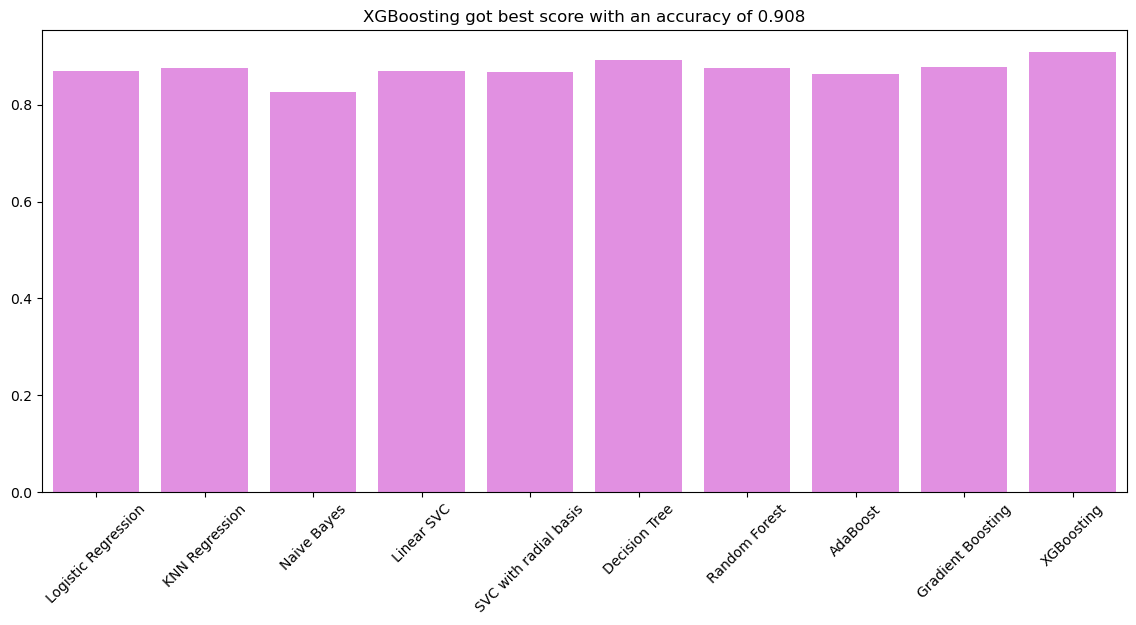

In [62]:
plt.figure(figsize=(14, 6))
sns.barplot(x=list(scores_df["model_name"]),
            y=list(scores_df["F1"]), color="violet")
plt.title(f"{best_score['model_name'][0]} got best score with an accuracy of {best_score['F1'][0]:.3f}")
plt.xticks(rotation=45)
plt.show()

### Compare model performance after cross validation

#### Calculate scores

In [63]:
scores_cv = {}
scores_cv['log_reg'] = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['knn'] = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['nb'] = cross_val_score(pipeline_nb, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['svm'] = cross_val_score(pipeline_svm, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['svm_rbf'] = cross_val_score(pipeline_svm_rbf, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['dtree'] = cross_val_score(pipeline_dtree, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['rf'] = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['ada_boost'] = cross_val_score(pipeline_ada_boost, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['gbm'] = cross_val_score(pipeline_gbm, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['xgb'] = cross_val_score(pipeline_xgb, X_train, y_train_le, cv=5, scoring='f1_weighted')

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solv

In [64]:
scores_cv_df = pd.DataFrame({
    "model_name" : scores_cv.keys(),
    'F1': [round(np.mean(scores), 3) for scores in scores_cv.values()]
})

scores_cv_df

,model_name,F1
0,log_reg,0.868
1,knn,0.866
2,nb,0.826
3,svm,0.864
4,svm_rbf,0.866
5,dtree,0.886
6,rf,0.876
7,ada_boost,0.859
8,gbm,0.871
9,xgb,0.892


#### Choose best score

In [65]:
best_score_cv = scores_cv_df[scores_cv_df["F1"] == scores_cv_df["F1"].max()].reset_index(drop=True)
best_score_cv

,model_name,F1
0,xgb,0.892


In [66]:
print(f"{best_score_cv['model_name'][0]} got best score with an accuracy of {best_score_cv['F1'][0]:.3f}")

xgb got best score with an accuracy of 0.892


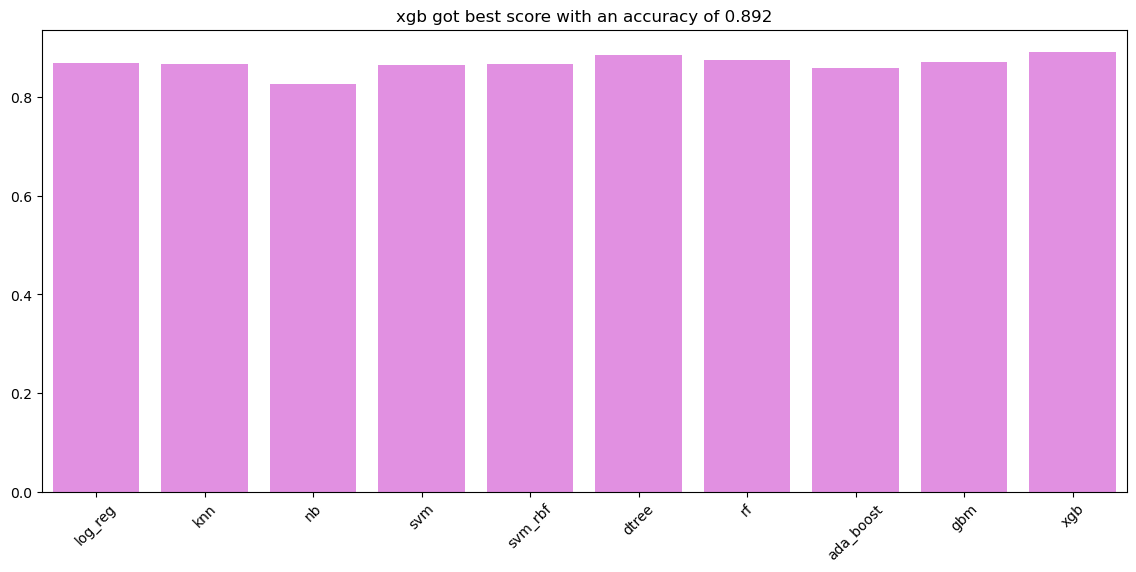

In [67]:
plt.figure(figsize=(14, 6))
sns.barplot(x=list(scores_cv_df["model_name"]),
            y=list(scores_cv_df["F1"]), color="violet")
plt.title(f"{best_score_cv['model_name'][0]} got best score with an accuracy of {best_score_cv['F1'][0]:.3f}")
plt.xticks(rotation=45)
plt.show()

# Hyperparameter tuning

 Approach
 1. Use Randomized Search to narrow down wide range of hyperparameters.
 2. Then use grid search to optimize in the close range of the result from RandomizedSearch

## Select best model (for hyperparameter tuning)

In [68]:
def assign_best_model(model_name):    

    model={}

    if model_name == "log_reg":
        best_model = LogisticRegression(random_state=42, solver='liblinear')
    elif model_name == "knn":
        best_model = KNeighborsClassifier()
    elif model_name == "nb":
        best_model = BernoulliNB()
    elif model_name == "svm":
        best_model = LinearSVC()
    elif model_name == "svm_rbf":
        best_model = SVC(kernel="rbf", gamma="scale")
    elif model_name == "dtree":
        best_model = DecisionTreeClassifier(random_state=42)
    elif model_name == "rf":
        best_model = RandomForestClassifier(random_state=42)
    elif model_name == "ada_boost":
        best_model = AdaBoostClassifier(random_state=42)
    elif model_name == "gbm":
        best_model = GradientBoostingClassifier(random_state=42)
    elif model_name == "xgb":
        best_model = XGBClassifier(random_state=42)    
    
    model["model"] = best_model

    need_scaling = ["log_reg", "knn","nb", "svm", "svm_rbf"]
    if model_name in need_scaling:
        model["needs_scaling"] = True
    else:
        model["needs_scaling"] = False
    
    return model

In [69]:
best_model = assign_best_model(best_score_cv['model_name'][0])
print(best_model)
best_model["model"]

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...), 'needs_scaling': False}


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Randomized Search

### Preprocessing and defining pipeline

In [70]:
def preprocess_model(model):
    if model["needs_scaling"] == True:
        categ_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
        num_transformer = Pipeline(steps=[("scaler", StandardScaler().set_output(transform="pandas"))])
        preprocessor = ColumnTransformer(transformers=[("num", num_transformer, numeric_features),
                                                       ("cat", categ_transformer, categorical_features)
                                                       ]).set_output(transform="pandas")
    else:
        categ_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
        preprocessor = ColumnTransformer(transformers=[("num", "passthrough", numeric_features),
                                                       ("cat", categ_transformer, categorical_features)
                                                       ]).set_output(transform="pandas")
        
    return preprocessor

In [71]:
best_model_preprocessor = preprocess_model(best_model)
best_model_preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,False


In [72]:
model_pipeline = Pipeline(steps=[
                              ("pre_process", best_model_preprocessor),
                              ("model", best_model["model"])
                              ])
model_pipeline

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Running the randomized search

In [73]:
# this works for different models
# ⚠️ "model" is the name from the pipeline!
rand_params = [
    {
        "model":[LogisticRegression(max_iter=1000, solver='liblinear')],
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__penalty": ["l1", "l2"]
    },
    {   "model": [KNeighborsClassifier()], 
        "model__n_neighbors": [1, 3, 5, 7, 9],
        "model__weights": ["uniform", "distance"]
    },
    {   "model": [BernoulliNB()],
        "model__alpha": [0.1, 0.5, 1.0]
    },
    {   "model": [LinearSVC(max_iter=2000)], 
        "model__C": [0.01, 0.1, 1, 5, 10, 100],
        "model__penalty": ["l2"],
        "model__loss": ["squared_hinge"]
    },
    {
        "model": [SVC()],
        "model__C": [0.01, 0.1, 1, 5, 10, 100],
        "model__kernel": ["rbf", "poly"],
        "model__gamma": ["scale"],
        "model__decision_function_shape": ["ovo", "ovr"]
    },
    {
        "model":[DecisionTreeClassifier()],
        "model__max_depth": [None, 3, 5, 7, 10],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },
    {
        "model": [RandomForestClassifier()],
        "model__n_estimators": list(range(50, 950, 100)),
        "model__max_depth": [None, 1, 2, 5, 7, 10, 15, 25, 40],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },
    {
        "model":[AdaBoostClassifier(random_state=42)],
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.01, 0.1, 0.5, 1.0]
    },
    {
        "model":[GradientBoostingClassifier(random_state=42)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.6, 0.8, 1.0]
    },
    {
        "model":[XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [3, 5, 7],
        "model__learning_rate": [0.01, 0.1, 0.2],
        "model__subsample": [0.6, 0.8, 1.0],
        "model__colsample_bytree": [0.6, 0.8, 1.0]
    }
]


- some searches need some hyperparametrization of the scoring, when the outcome is more than 2 options

In [74]:
# Define scoring for multiclass
scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

In [75]:
rand_cv = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=rand_params,
    cv=5,
    n_iter=25,
    scoring=scoring,   
    refit='f1_weighted',
    verbose=1, 
    n_jobs=-1,
    error_score='raise'
)

- In case best model is XGBoost &rarr; XGBoost doesn't work with string y labels &rarr; remember to label encode before fitting

In [76]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

In [77]:
model_name = best_model["model"].__class__.__name__
model_name

'XGBClassifier'

In [78]:
# i don't which models wiill give the follwoing error
# ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['Bronze' 'Gold' 'Silver' 'no medal']
try:
    rand_cv.fit(X_train, y_train)
except ValueError:
    rand_cv.fit(X_train, y_train_le)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [79]:
print(f"Best F1-score: {rand_cv.best_score_:.3f}\n")
print("-------------------------------------------------------------")
print(f"Best parameter set: {rand_cv.best_params_}\n")
print("-------------------------------------------------------------")

try:
    print(f"Scores:\n {classification_report(y_train, rand_cv.predict(X_train))}")
except ValueError:
    print(f"Scores:\n {classification_report(y_train_le, rand_cv.predict(X_train))}")

Best F1-score: 0.886

-------------------------------------------------------------
Best parameter set: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8, 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_sta

In [ ]:
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(mapping)

## Grid Search

### Getting best model with best params after randomized search

In [80]:
params = rand_cv.best_params_ 
print(type(params))
params

<class 'dict'>


{'model__subsample': 0.8,
 'model__n_estimators': 200,
 'model__max_depth': 5,
 'model__learning_rate': 0.1,
 'model__colsample_bytree': 0.8,
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=None, ...)}

In [81]:
grid_model = params["model"]
grid_model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


⚠️ maybe automate this in the future? can i use the same params as for rnaodm search?

In [82]:
grid_params = [
    {
        'model__n_estimators': list(range(250, 450, 20)),
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        'model__max_depth': list(range(1,10,1)),
    }
]

### Preprocessing and defining pipeline

In [83]:
def needs_scaling(model_name):    
    need_scaling = [LogisticRegression(), KNeighborsClassifier(),BernoulliNB(), LinearSVC(), SVC()]
    if model_name in need_scaling:
        return True
    else:
        return False

In [84]:
def preprocess_grid_model(model):
    if needs_scaling(model) == True:
        categ_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
        num_transformer = Pipeline(steps=[("scaler", StandardScaler().set_output(transform="pandas"))])
        preprocessor = ColumnTransformer(transformers=[("num", num_transformer, numeric_features),
                                                       ("cat", categ_transformer, categorical_features)
                                                       ]).set_output(transform="pandas")
    else:
        categ_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
        preprocessor = ColumnTransformer(transformers=[("num", "passthrough", numeric_features),
                                                       ("cat", categ_transformer, categorical_features)
                                                       ]).set_output(transform="pandas")
        
    return preprocessor

In [85]:
grid_model_preprocessor = preprocess_grid_model(grid_model)

In [86]:
grid_model_pipeline = Pipeline(steps=[
                              ("pre_process", best_model_preprocessor),
                              ("model", best_model["model"])
                              ])
grid_model_pipeline

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [87]:
# because the outcome is not binary, the 

In [88]:
grid_cv = GridSearchCV(
    grid_model_pipeline, 
    grid_params, 
    cv=5, 
    scoring=["f1", "accuracy"], 
    refit="f1",
)

In [89]:
grid_cv.fit(X_train, y_train) 

ValueError: 
All the 4050 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4050 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\xgboost\sklearn.py", line 1471, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['Bronze' 'Gold' 'Silver' 'no medal']


In [ ]:
print(f"Best F1-score: {grid_cv.best_score_:.3f}\n")
print("-------------------------------------------------------------")
print(f"Best parameter set: {grid_cv.best_params_}\n")
print("-------------------------------------------------------------")
print(f"Scores:\n {classification_report(y_train, grid_cv.predict(X_train))}")

In [ ]:
preds = grid_cv.predict(X_test)
print(f"Scores:\n {classification_report(y_test, preds)}\n")
print(f"F1-score: {f1_score(y_test, preds):.3f}")

In [ ]:
confusion_matrix(y_test, preds) 

# Stacking classifier